# Anomaly Detection

This notebook analyzes a dataset on household electricity usage.


## Import libraries

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the data
Heads up: The Date_Time parsing takes a while.

In [17]:
data_path = 'train.txt'

data = pd.read_csv(data_path, parse_dates=[['Date', 'Time']])

data.head(10)

,Date_Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,NaN,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.36000,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,NaN,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.38800,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,NaN,0.528,235.68,15.8,0.0,1.0,17.0
5,2006-12-16 17:29:00,3.52000,0.522,235.02,15.0,0.0,2.0,17.0
6,2006-12-16 17:30:00,3.70200,0.520,235.09,15.8,0.0,1.0,17.0
7,2006-12-16 17:31:00,3.70000,0.520,235.22,15.8,0.0,1.0,17.0
8,2006-12-16 17:32:00,3.66800,0.510,233.99,15.8,0.0,1.0,17.0
9,2006-12-16 17:33:00,NaN,0.510,233.86,15.8,0.0,2.0,16.0


### Observe the imperfections in the data

In [5]:
data.isnull().sum()

Date_Time                   0
Global_active_power        24
Global_reactive_power    8348
Voltage                  8348
Global_intensity         8348
Sub_metering_1           8348
Sub_metering_2           8348
Sub_metering_3           8348
dtype: int64

### Cleaning the data

The function above shows that there are 8348 null values in multiple columns, and 24 null values in Global_active_power.

We will need to remove those to clean the dataset.

The pandas dropna() function removes all rows that have any null values. 

The sum of null values afterwards should be 0.

In [28]:
#data = data.dropna();
#data.isnull().sum()
print("Not cleaning the dataset - Turns out we need the rows that have null fields because they contain interesting data.")

Not cleaning the dataset - Turns out we need the rows that have null fields because they contain interesting data.


## Understanding the data

The data is split into 9 columns;

* **Date**: Date in format dd/mm/yyyy
* **Time**: Time in format hh:mm:ss
* **Global_active_power**: Household global minute-averaged active power (in kilowatts)
* **Global_reactive_power: Household global minute-averaged reactive power (in kilowatts)
* **Voltage**: Minute-averaged voltage (in volts)
* **Global_intensity**: Household global minute-averaged current intensity (in ampere)
* **Sub_metering_1**: Energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
* **Sub_metering_2**: Energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a regrigerator and a light.
* **Sub_metering_3**: Energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [7]:
data.head(10)

,Date_Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
5,2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
8,2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0
10,2006-12-16 17:34:00,4.448,0.498,232.86,19.6,0.0,1.0,17.0
15,2006-12-16 17:39:00,3.384,0.282,237.14,14.2,0.0,0.0,17.0
18,2006-12-16 17:42:00,3.266,0.000,237.13,13.8,0.0,0.0,18.0
20,2006-12-16 17:44:00,5.894,0.000,232.69,25.4,0.0,0.0,16.0


## A quick look at the first 30 days

Global Active Power vs Time for the first 30 days (30 days * 24 hours * 60 minutes)

### Interesting point in time (January 1)
Global active power drops at 14:00 on January 1

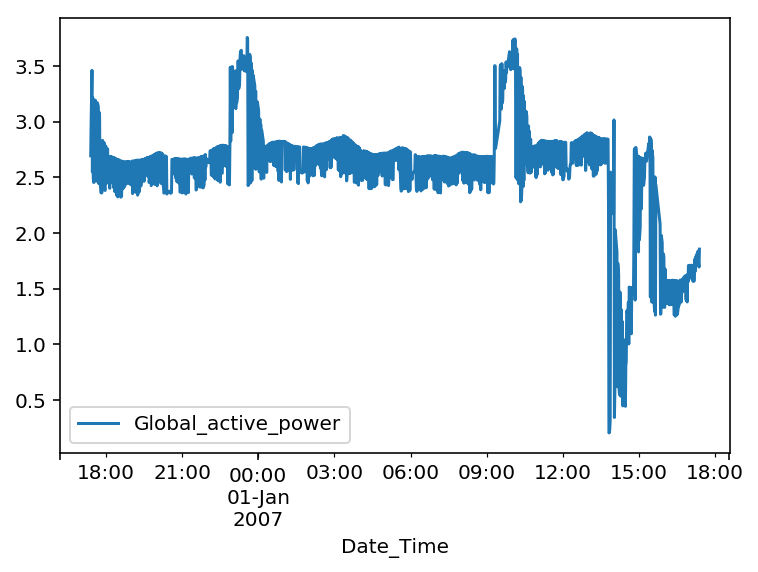

In [23]:
data[15*24*60:16*24*60].plot(x='Date_Time', y='Global_active_power')

### Interesting point in time (December 31)
Global active power is erratic in the night on December 31

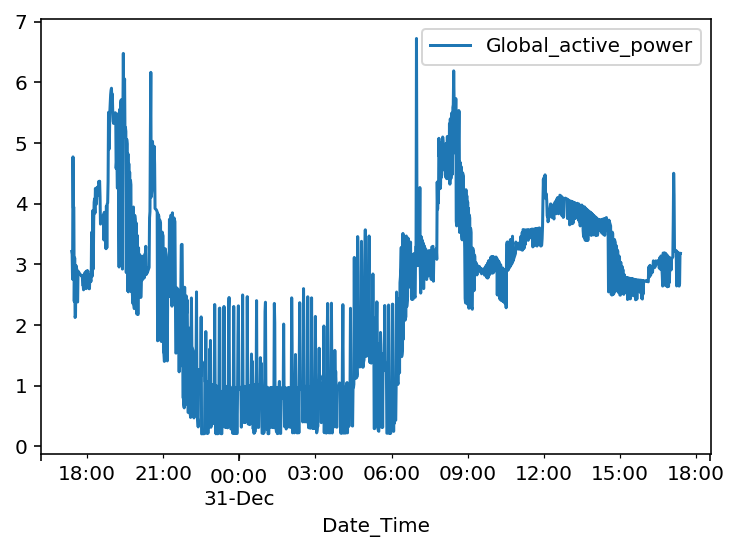

In [24]:
data[14*24*60:15*24*60].plot(x='Date_Time', y='Global_active_power')

In [11]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1.548072e+06,1.548072e+06,1.548072e+06,1.548072e+06,1.548072e+06,1.548072e+06,1.548072e+06
mean,1.227778e+00,1.218387e-01,2.405478e+02,4.642035e+00,1.156050e+00,1.359002e+00,6.166487e+00
std,1.057457e+00,1.116499e-01,3.261038e+00,4.578895e+00,6.275397e+00,6.023511e+00,8.315095e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.540000e-01,4.600000e-02,2.386700e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.158250e-01,1.000000e-01,2.407800e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.699200e+00,1.920000e-01,2.426700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.539400e+02,4.840000e+01,8.200000e+01,7.800000e+01,3.100000e+01
